In [1]:
import math
import torch
import gpytorch
import tqdm
from matplotlib import pyplot as plt

In [5]:
num_latents = 3
num_tasks = 4

class MultitaskGPModel(gpytorch.models.ApproximateGP):
    def __init__(self):
        # Let's use a different set of inducing points for each latent function
        inducing_points = torch.rand(num_latents, 16, 2)

        # We have to mark the CholeskyVariationalDistribution as batch
        # so that we learn a variational distribution for each task
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            inducing_points.size(-2), batch_shape=torch.Size([num_latents])
        )

        # We have to wrap the VariationalStrategy in a LMCVariationalStrategy
        # so that the output will be a MultitaskMultivariateNormal rather than a batch output
        variational_strategy = gpytorch.variational.LMCVariationalStrategy(
            gpytorch.variational.VariationalStrategy(
                self, inducing_points, variational_distribution, learn_inducing_locations=True
            ),
            num_tasks=4,
            num_latents=3,
            latent_dim=-1
        )

        super().__init__(variational_strategy)

        # The mean and covariance modules should be marked as batch
        # so we learn a different set of hyperparameters
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([num_latents]))
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([num_latents])),
            batch_shape=torch.Size([num_latents])
        )

    def forward(self, x):
        # Forward function now handles 2D input
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
# Prepare the 2D input data
train_x1 = torch.linspace(0, 1, 10)
train_x2 = torch.linspace(0, 1, 10)
train_x1_2d, train_x2_2d = torch.meshgrid(train_x1, train_x2)
train_x_2d = torch.stack([train_x1_2d.flatten(), train_x2_2d.flatten()], -1)

# Modify the train_y generation to match the 2D input
train_y = torch.stack([
    torch.sin(train_x_2d[:, 0] * (2 * math.pi)) + torch.randn(train_x_2d[:, 0].size()) * 0.2,
    torch.cos(train_x_2d[:, 1] * (2 * math.pi)) + torch.randn(train_x_2d[:, 1].size()) * 0.2,
    torch.sin(train_x_2d[:, 0] * (2 * math.pi)) + 2 * torch.cos(train_x_2d[:, 1] * (2 * math.pi)) + torch.randn(train_x_2d[:, 0].size()) * 0.2,
    -torch.cos(train_x_2d[:, 1] * (2 * math.pi)) + torch.randn(train_x_2d[:, 1].size()) * 0.2,
], -1)

# Initialize the model and likelihood
num_latents = 3
num_tasks = 4
model = MultitaskGPModel()
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_tasks)

# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
num_epochs = 1 if smoke_test else 500


model.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.1)

# Our loss object. We're using the VariationalELBO, which essentially just computes the ELBO
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_y.size(0))

# We use more CG iterations here because the preconditioner introduced in the NeurIPS paper seems to be less
# effective for VI.
epochs_iter = tqdm.tqdm_notebook(range(num_epochs), desc="Epoch")
for i in epochs_iter:
    # Within each iteration, we will go over each minibatch of data
    optimizer.zero_grad()
    output = model(train_x_2d)
    loss = -mll(output, train_y)
    epochs_iter.set_postfix(loss=loss.item())
    loss.backward()
    optimizer.step()

/var/folders/c9/xpcdzsn55474rmzrqh4kx1cw0000gn/T/ipykernel_40480/2035695645.py:80: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  epochs_iter = tqdm.tqdm_notebook(range(num_epochs), desc="Epoch")


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

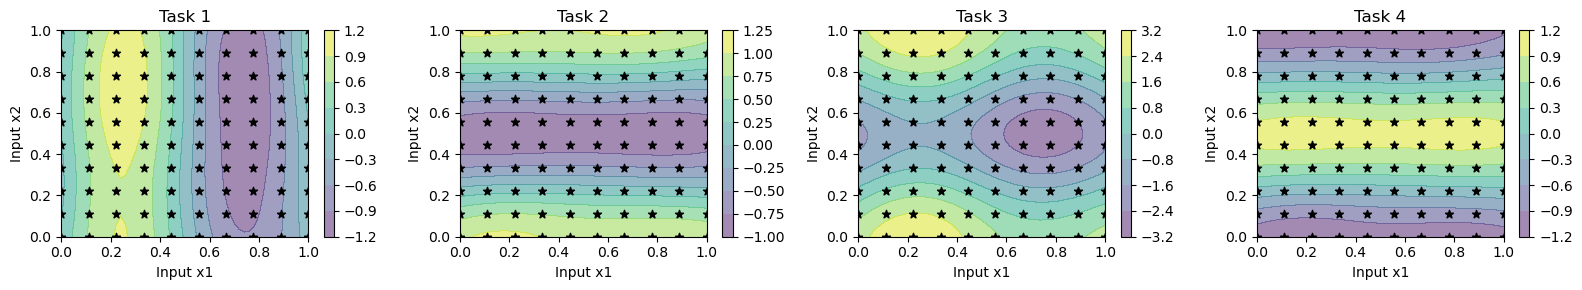

In [6]:
import matplotlib.pyplot as plt
import torch
import gpytorch

# Set into eval mode
model.eval()
likelihood.eval()

# Create a 2D grid for test_x
test_x1 = torch.linspace(0, 1, 51)
test_x2 = torch.linspace(0, 1, 51)
test_x1_2d, test_x2_2d = torch.meshgrid(test_x1, test_x2)
test_x_2d = torch.stack([test_x1_2d.flatten(), test_x2_2d.flatten()], -1)

# Initialize plots
fig, axs = plt.subplots(1, num_tasks, figsize=(4 * num_tasks, 3))

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions = likelihood(model(test_x_2d))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

for task, ax in enumerate(axs):
    # Since our inputs are 2D, we need to reshape the outputs for plotting
    mean_2d = mean[:, task].view(test_x1_2d.shape)
    lower_2d = lower[:, task].view(test_x1_2d.shape)
    upper_2d = upper[:, task].view(test_x1_2d.shape)

    # Plotting the mean as a contour plot
    contour = ax.contourf(test_x1_2d.numpy(), test_x2_2d.numpy(), mean_2d.numpy(), alpha=0.5)
    fig.colorbar(contour, ax=ax)

    # Add training data points
    train_points = train_x_2d[train_y[:, task] != 0]  # Assuming non-zero points are training points
    ax.scatter(train_points[:, 0].numpy(), train_points[:, 1].numpy(), color='k', marker='*')

    ax.set_title(f'Task {task + 1}')
    ax.set_xlabel('Input x1')
    ax.set_ylabel('Input x2')

fig.tight_layout()
plt.show()
